<div align="center" style="font-family: Arial, sans-serif; background-color: #f0f0f0; padding: 100px; border-radius: 10px; width: 80%; margin: auto;">
    <h2 style="font-size: 24px; font-weight: bold; text-decoration: underline;">Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)</h2>
    <div style="font-size: 18px; margin-top: 20px; text-align: left;">
        <strong><h4 style="color: #2E64FE; font-weight: bold; text-align: center;">Выбор начальных условий:</strong></h2>
        <ul style="list-style-type: none; padding-left: 0;color: #333;">
            <li>- Выбрать набор данных для задачи семантической сегментации (у каждого студента должен быть уникальный набор данных) и обосновать его выбор (реальная практическая задача).</li>
            <li>- Выбрать метрики качества и обосновать их выбор.</li>
        </ul>
        <strong><h4 style="color: #2E64FE; font-weight: bold; text-align: center;">Создание бейзлайна и оценка качества:</strong></h2>
        <ul style="list-style-type: none; padding-left: 0;color: #333;">
            <li>- Обучить модели из sklearn (для классификации и регрессии) для выбранных наборов данных.</li>
            <li>- Оценить качество моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных.</li>
        </ul>
        <strong><h4 style="color: #2E64FE; font-weight: bold; text-align: center;">Улучшение бейзлайна:</strong></h2>
        <ul style="list-style-type: none; padding-left: 0;color: #333;">
            <li>- Сформулировать гипотезы (препроцессинг данных, визуализация данных, формирование новых признаков, подбор гиперпараметров на кросс-валидации и т.д.).</li>
            <li>- Проверить гипотезы.</li>
            <li>- Сформировать улучшенный бейзлайн по результатам проверки гипотез.</li>
            <li>- Обучить модели с улучшенным бейзлайном (для классификации и регрессии) для выбранных наборов данных.</li>
            <li>- Оценить качество моделей с улучшенным бейзлайном (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных.</li>
            <li>- Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2.</li>
            <li>- Сделать выводы.</li>
        </ul>
    </div>
</div>


### Импортируем библиотеки

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, RandomSizedCrop, OneOf, PadIfNeeded

print(torch.__version__) 
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))


2.2.2+cu118
True
NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-light.mplstyle')
# plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-dark.mplstyle')

try: 
    plt.rcParams.update({
        'text.usetex': True,
        'text.latex.preamble': r'\usepackage[utf8]{inputenc}\usepackage[russian]{babel}',
        'axes.labelsize': 21, # названия осей 
        'xtick.labelsize': 16, # значения осей 
        'ytick.labelsize': 16, # значения осей
        'legend.fontsize': 16,  
        'axes.titlesize': 16,
    })
except: 
    plt.rcParams.update({
        'axes.labelsize': 21, # названия осей 
        'xtick.labelsize': 16, # значения осей 
        'ytick.labelsize': 16, # значения осей
        'legend.fontsize': 16,  
        'axes.titlesize': 16,
    })

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

<div align="center" style="font-family: Arial, sans-serif; background-color: #f0f0f0; padding: 90px; border-radius: 10px; width: 90%; margin: auto;">
    <div style="font-size: 18px; margin-top: 20px; text-align: left;">
        <strong><h4 style="color: #2E64FE; font-weight: bold; text-align: center;">1.1: Выбор данных для классификации</h4></strong>
        <ul style="list-style-type: none; padding-left: 0; color: #333;">
            <li><a style="color: #2E64FE; font-weight: bold;">Набор данных PASCAL VOC</a></li>
            <li>
                Набор данных PASCAL VOC (Visual Object Classes) представляет собой коллекцию изображений, аннотированных для задач классификации, детекции и семантической сегментации. Он включает изображения с 20 различными классами объектов, что делает его идеальным для решения задач многоклассовой классификации.
                <br><br>
                <strong>Реальная практическая задача:</strong>
                <br>
                Выбор данного набора данных обоснован его широким применением в задачах компьютерного зрения. Он предоставляет стандартизированную платформу для оценки и сравнения различных алгоритмов, что способствует прогрессу в области автоматического распознавания объектов и их сегментации.
            </li>
        </ul>
    </div>
</div>


<div align="center" style="font-family: Arial, sans-serif; background-color: #f0f0f0; padding: 20px; border-radius: 60px; width: 80%;">
    <div style="font-size: 18px; text-align: left;">
        <strong><h4 style="color: #2E64FE; font-weight: bold; text-align: center;">Оценка моделей:</strong></h2>
        <ul style="list-style-type: none; padding-left: 0;color: #333;">
            <li><strong>Метрика для сегментации:</strong> IoU (Intersection over Union).</li>
            <li><strong>  

  $\text{Mean Pixel Accuracy} = \frac{1}{C} \sum_{i=1}^{C} \frac{TP_i}{TP_i + FN_i}$

  </strong> Это улучшенная версия Pixel Accuracy, где точность рассчитывается для каждого класса, а затем усредняется. Pixel Accuracy измеряет процент пикселей, которые были правильно классифицированы моделью (с учетом всех классов).</li>
        </ul>
    </div>
</div>





In [4]:
VOC_CLASSES = [
    'background',  # 0
    'aeroplane',   # 1
    'bicycle',     # 2
    'bird',        # 3
    'boat',        # 4
    'bottle',      # 5
    'bus',         # 6
    'car',         # 7
    'cat',         # 8
    'chair',       # 9
    'cow',         # 10
    'diningtable', # 11
    'dog',         # 12
    'horse',       # 13
    'motorbike',   # 14
    'person',      # 15
    'potted plant',# 16
    'sheep',       # 17
    'sofa',        # 18
    'train',       # 19
    'tv/monitor'   # 20
]


In [5]:
VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

#### Загрузка данных для классификации

In [6]:
class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        height, width = mask.shape[:2]

        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)

        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):

        image = cv2.imread(self.images[index])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)

        mask = mask.permute(2,0,1)

        return image, mask
    
train_dataset = PascalVOCSearchDataset(
    './data',
    download = True, 
    transform = Compose([
        PadIfNeeded(448, 448),
        RandomBrightnessContrast(),
        OneOf([
            RandomCrop(256, 256, p=0.2),
            RandomSizedCrop((224, 448), (256, 256))
        ], p=1)
    ])
)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


In [7]:
train_dataset[0][1].shape

torch.Size([21, 256, 256])

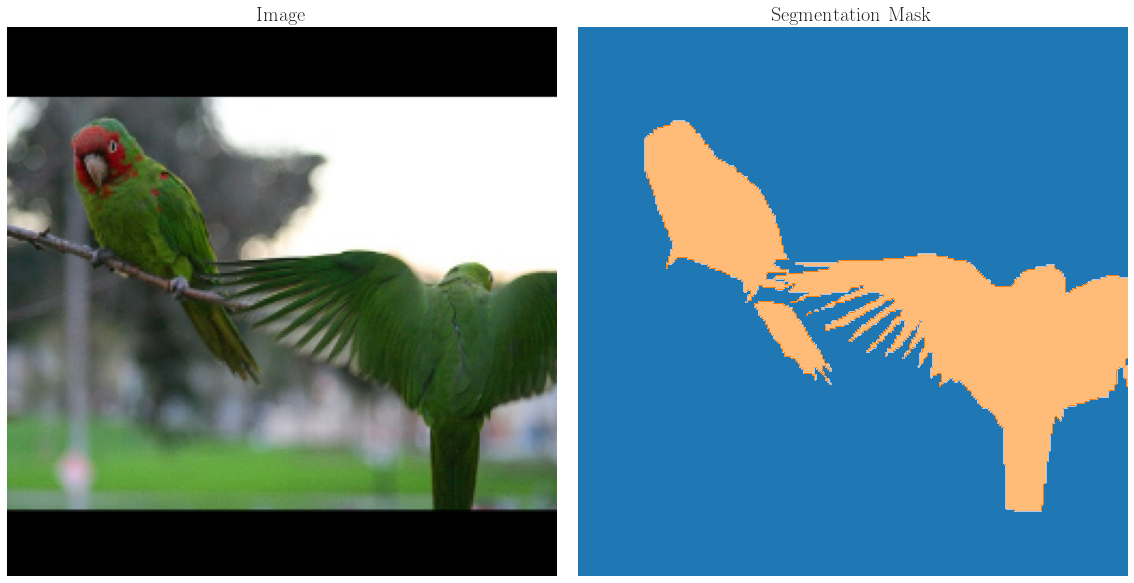

In [27]:
image, targets = train_dataset[11]

fig, ax = plt.subplots(1, 2, figsize=(16, 8)) 
ax = ax.ravel()

ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title('Image', fontsize=20)
ax[0].axis('off')

ax[1].imshow(targets.argmax(0), vmin=0, vmax=19, cmap='tab20')
ax[1].set_title('Segmentation Mask', fontsize=20)
ax[1].axis('off')

plt.tight_layout()
plt.show()


In [9]:
dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)

In [ ]:
import segmentation_models_pytorch as smp


model = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",    
    encoder_weights="imagenet",           
    in_channels=3,                        
    classes=len(VOC_CLASSES)              
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [11]:
device

device(type='cuda')

In [12]:
def IoU(real, pred, classes_num=21):
    batch_size = real.shape[0]
    height, width = real.shape[1:]
    
    real = F.one_hot(real, num_classes=classes_num)  # (B, H, W, C)
    real = real.permute(0, 3, 1, 2)                  # (B, C, H, W)
    real = real.reshape(batch_size, classes_num, -1) # (B, C, H*W)

    pred = F.one_hot(pred.argmax(dim=1), num_classes=classes_num)  # (B, H, W, C)
    pred = pred.permute(0, 3, 1, 2)                                # (B, C, H, W)
    pred = pred.reshape(batch_size, classes_num, -1)              # (B, C, H*W)

    intersection = (real & pred).sum(dim=-1)  # (B, C)
    union = (real | pred).sum(dim=-1)         # (B, C)
    iou = intersection.float() / (union.float() + 1e-6)  # avoid division by zero

    return iou

def MIoU(real, pred):
    iou = IoU(real, pred)
    return iou.nanmean(dim=1)  # Среднее по классам для каждого изображения

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-5)
criterion = torch.nn.CrossEntropyLoss()

losses = []
miou = []

rloss = 0

for epoch in range(4):

    cur_loss = 0
    cur_miou = 0
    amount = 0
    for image, targets in tqdm(dataloader):
        targets = targets.long().to(device)  
        targets = targets.argmax(dim=1)    
        image = image.float().to(device)

        predict = model(image)['out']
        targets = targets.squeeze(1)

        loss = criterion(predict, targets)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        rloss += loss.detach().cpu().item() / len(dataloader)

        amount += len(image)
        cur_loss += loss.detach().cpu().item()
        cur_miou += MIoU(targets.detach().cpu(), predict.detach().cpu()).sum()

    miou.append(cur_miou / amount)

    losses += [rloss]
    print(f"previous rloss: [{rloss:.3f}]")
    rloss = 0

100%|██████████| 183/183 [06:47<00:00,  2.23s/it]


previous rloss: [0.450]


100%|██████████| 183/183 [06:29<00:00,  2.13s/it]


previous rloss: [0.388]


100%|██████████| 183/183 [06:29<00:00,  2.13s/it]


previous rloss: [0.356]


100%|██████████| 183/183 [06:32<00:00,  2.15s/it]

previous rloss: [0.355]


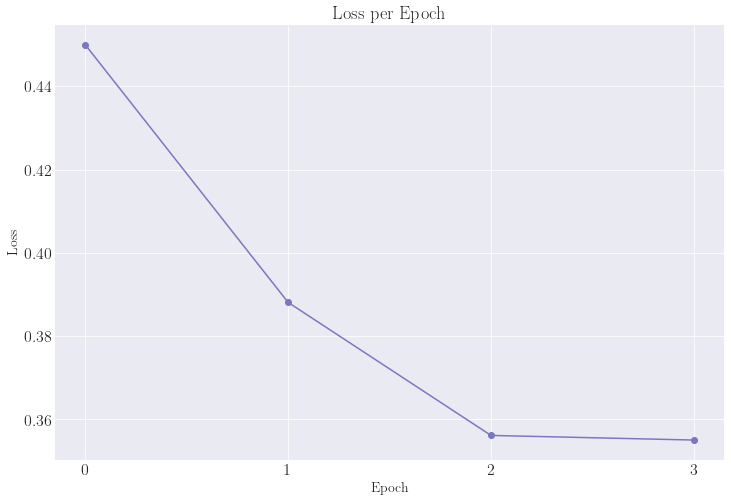

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(losses, marker='o', linestyle='-')
plt.title('Loss per Epoch', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.xticks(range(len(losses)))
plt.show()


C:\Users\ilya\AppData\Local\Temp\ipykernel_24548\2699377446.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


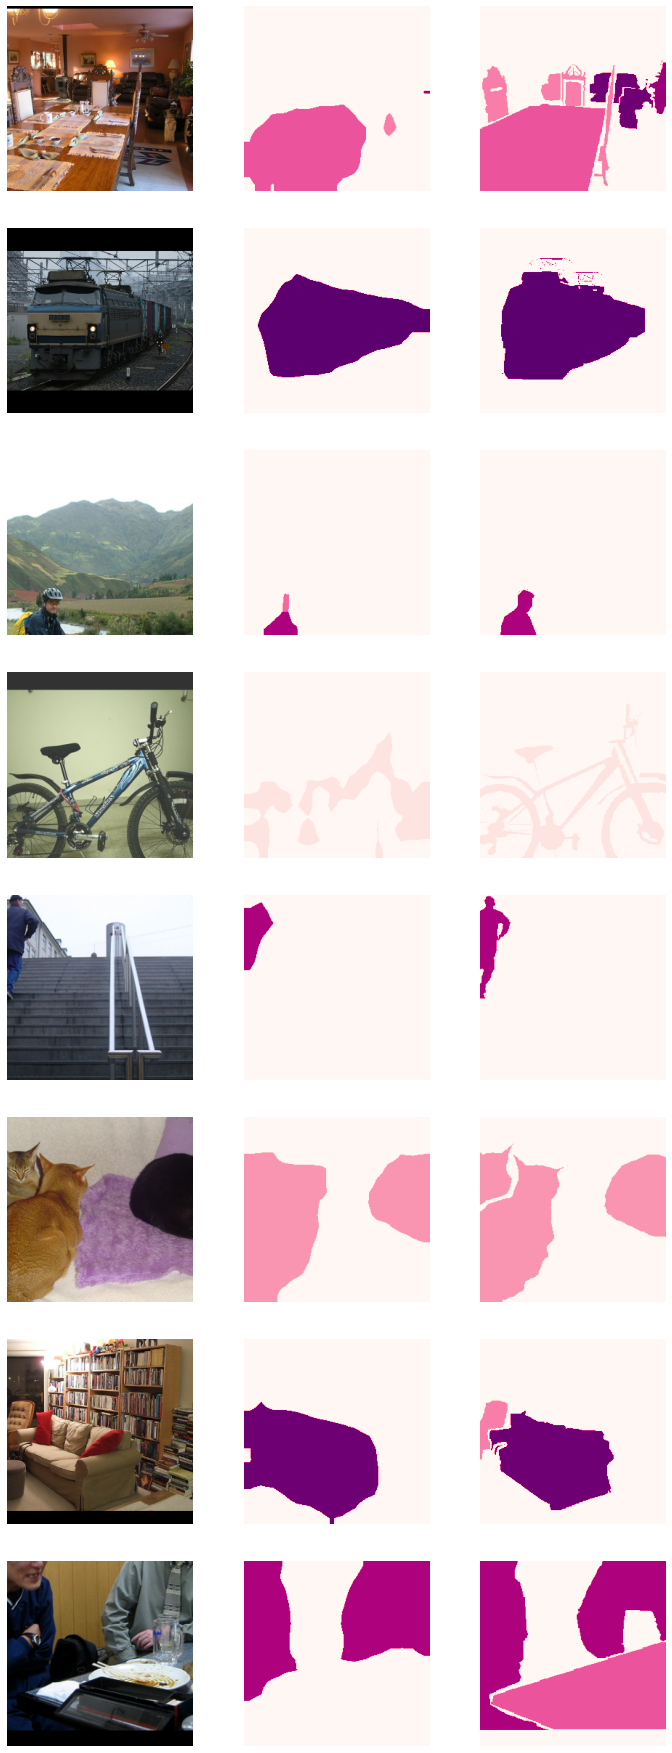

In [17]:
fig,axes = plt.subplots(
  len(targets), 3, figsize = (12, len(targets) * 4)
)

for idc, (simg, spred, slbl) in enumerate(zip(image.detach().cpu(), predict.detach().cpu().softmax(1), targets.detach().cpu())):
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl, vmin = 0, vmax = len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]

fig.show()

---

Попробуем улучшить бейзайл

---

In [ ]:
model = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",    
    encoder_weights="imagenet",           
    in_channels=3,                        
    classes=len(VOC_CLASSES)              
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-5, weight_decay = 1e-5)
dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
criterion = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

losses = []
miou = []

rloss = 0

for epoch in range(4):

    cur_loss = 0
    cur_miou = 0
    amount = 0
    for image, targets in tqdm(dataloader):
        targets = targets.long().to(device)  
        targets = targets.argmax(dim=1)    
        image = image.float().to(device)

        predict = model(image)['out']
        targets = targets.squeeze(1)

        loss = criterion(predict, targets)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        rloss += loss.detach().cpu().item() / len(dataloader)

        amount += len(image)
        cur_loss += loss.detach().cpu().item()
        cur_miou += MIoU(targets.detach().cpu(), predict.detach().cpu()).sum()

    miou.append(cur_miou / amount)

    losses += [rloss]
    print(f"previous rloss: [{rloss:.3f}]")
    rloss = 0

100%|██████████| 183/183 [06:09<00:00,  2.02s/it]


previous rloss: [0.336]


100%|██████████| 183/183 [06:32<00:00,  2.15s/it]


previous rloss: [0.315]


100%|██████████| 183/183 [06:36<00:00,  2.17s/it]


previous rloss: [0.316]


100%|██████████| 183/183 [06:36<00:00,  2.17s/it]

previous rloss: [0.296]


C:\Users\ilya\AppData\Local\Temp\ipykernel_24548\2043752796.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


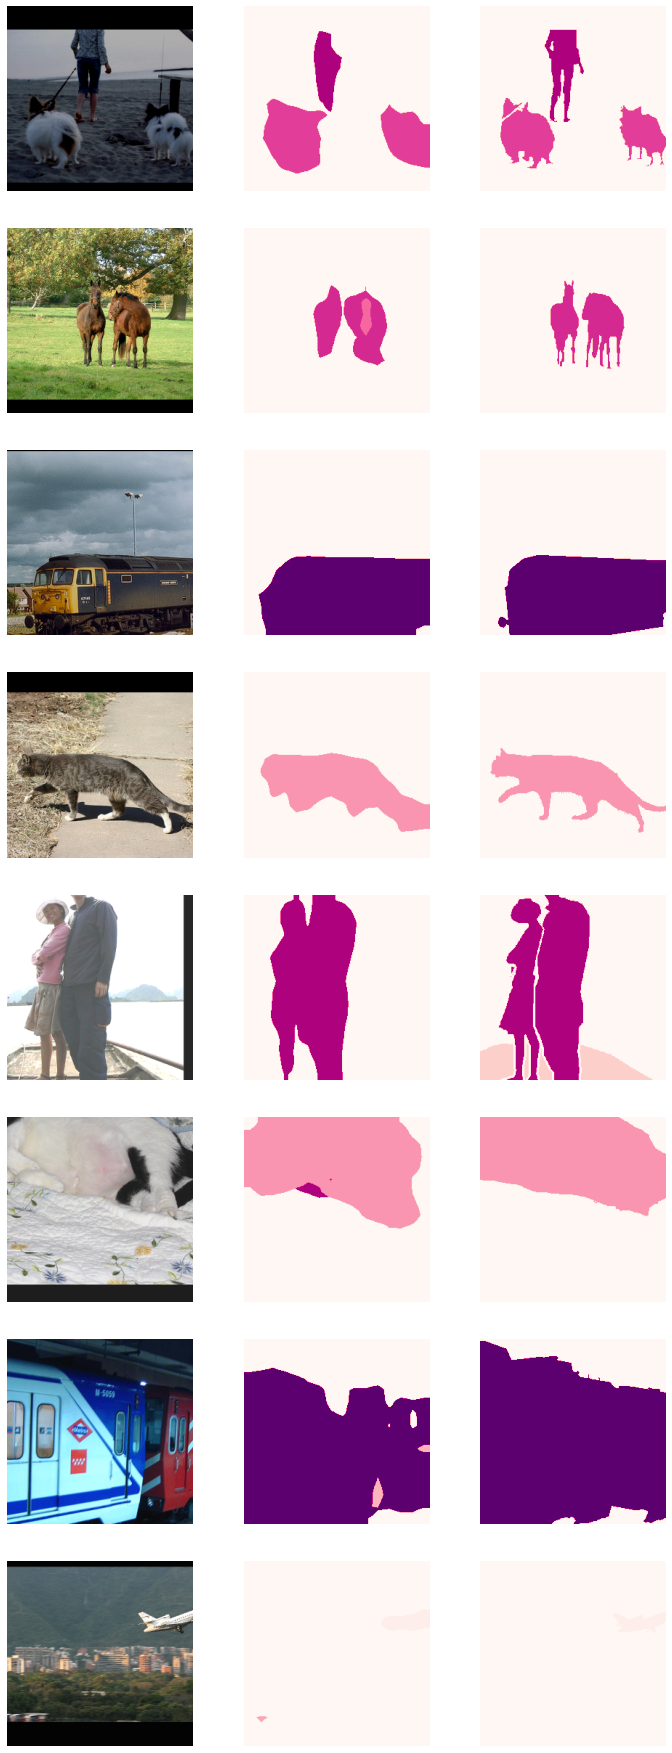

In [21]:
fig,axes = plt.subplots(len(targets), 3, figsize = (12, len(targets) * 4))
for idc, (simg, spred, slbl) in enumerate(zip(image.detach().cpu(), predict.detach().cpu().softmax(1), targets.detach().cpu())):
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl, vmin = 0, vmax = len(VOC_CLASSES)-1)
[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()



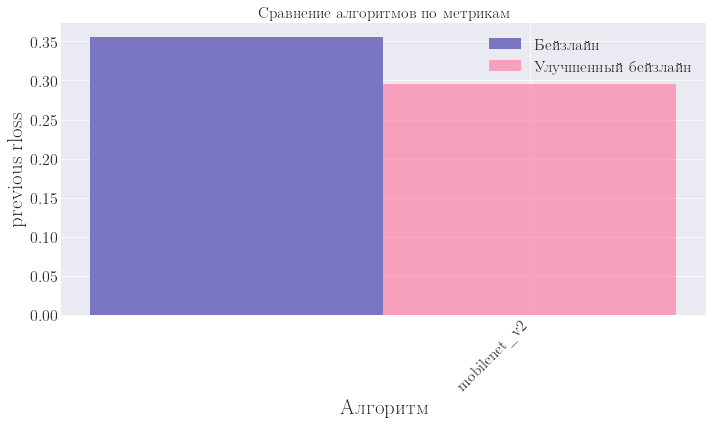

In [30]:

algorithms = [
    "mobilenet_v2"
]


baseline = [
    0.355
]

improved_baseline = [
    0.296
]


x = np.arange(len(algorithms))
width = 0.1

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, baseline, width, label='Бейзлайн')
rects2 = ax.bar(x, improved_baseline, width, label='Улучшенный бейзлайн')

ax.set_xlabel('Алгоритм')
ax.set_ylabel('previous rloss')
ax.set_title('Сравнение алгоритмов по метрикам')
ax.set_xticks(x)
ax.set_xticklabels(algorithms, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


---

В итоге получилось сделать предикативную модель для семантической сегментации. 

Чтобы улучшить производительность модели, добавил сильные аугментации.
